# Cargar Imágenes

In [1]:
import requests
import zipfile
import io
import warnings
import os
import shutil
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)

2025-09-02 00:18:46.022606: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-02 00:18:46.022954: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 00:18:46.070561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-02 00:18:47.522231: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [ ]:
url = "https://storage.googleapis.com/datascience-materials/dogs-vs-cats.zip"
response = requests.get(url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("../data")

In [2]:
images_folder = "../data/dogs-vs-cats/train"
train_folder = "../data/train"
cats_folder = "../data/all/cats"
dogs_folder = "../data/all/dogs"

In [ ]:
os.makedirs(train_folder, exist_ok=True)
os.makedirs(cats_folder, exist_ok=True)
os.makedirs(dogs_folder, exist_ok=True)

for filename in os.listdir(images_folder):
    file_path = os.path.join(images_folder, filename)
    if os.path.isfile(file_path):
        if filename.lower().startswith("cat"):
            shutil.move(file_path, os.path.join(cats_folder, filename))
        elif filename.lower().startswith("dog"):
            shutil.move(file_path, os.path.join(dogs_folder, filename))

## Dividimos las imágenes en grupos de entrenamiento y pruebas

In [3]:
source_dir = "../data/all"
train_dir = "../data/train"
test_dir = "../data/test"

In [4]:
cats_folder = os.path.join(source_dir, "cats")
dogs_folder = os.path.join(source_dir, "dogs")

cats = len(os.listdir(cats_folder))
dogs = len(os.listdir(dogs_folder))

# sample 1% of each class
p_cats = int(cats * 0.05)
p_dogs = int(dogs * 0.05)

# split 80/20 train/test
n_cats_train = int(p_cats * 0.8)
n_cats_test = p_cats - n_cats_train

n_dogs_train = int(p_dogs * 0.8)
n_dogs_test = p_dogs - n_dogs_train

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ["cats", "dogs"]

for cls in classes:
    cls_path = os.path.join(source_dir, cls)
    files = os.listdir(cls_path)
    random.shuffle(files)  # shuffle to avoid bias

    if cls == "cats":
        selected_files = files[:p_cats]
        train_files = selected_files[:n_cats_train]
        test_files = selected_files[n_cats_train:]
    else:
        selected_files = files[:p_dogs]
        train_files = selected_files[:n_dogs_train]
        test_files = selected_files[n_dogs_train:]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    for f in train_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(train_dir, cls, f))
    for f in test_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(test_dir, cls, f))

    print(f"{cls}: {len(train_files)} train, {len(test_files)} test")

cats: 500 train, 125 test
dogs: 500 train, 125 test


## Reescalamos las imágenes

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(224, 224),
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    batch_size=32
                                                    )

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  target_size=(224, 224),
                                                  class_mode='binary',
                                                  shuffle=False,
                                                  batch_size=32
                                                  )

Found 1000 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


Configurando shuffle = True en train_generator, garantizamos que las imágenes de entrenamiento se mezclen en cada epoch, evitando que el modelo aprenda patrones del orden. Por otro lado, al configurar shuffle = False en test_generator mantenemos siempre el mismo orden para poder comparar con y_true al evaluar.

# Construir un ANN

## Inicializamos el Modelo

Usaremos una configuración sencilla para poder entrenar el modelo

In [7]:
set_random_seed(42)

model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation="relu"),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

2025-09-02 00:19:29.079031: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Definimos las épocas del entrenamiento y el tamaño de los lotes

In [8]:
epochs = 150  
batch_size = 32  

## Entrenamos el Modelo

In [9]:
model_history = model.fit(  
    train_generator,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = train_generator.samples // batch_size)

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 894ms/step - accuracy: 0.5290 - loss: 0.8461 - val_accuracy: 0.5000 - val_loss: 0.6888
Epoch 2/150


KeyboardInterrupt: 

Después de entrenar el modelo con 150 épocas, podemos ver que está aprendiendo bastante bien sobre los datos de entrenamiento, aunque no alcanza una precisión alta. La precisión en los datos de validación es significativamente menor que en entrenamiento, lo que indica que el modelo no generaliza tan bien en datos nuevos. La pérdida en validación es mucho mayor que en entrenamiento.

In [10]:
loss, accuracy = model.evaluate(train_generator)
print(f"Train Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 374ms/step - accuracy: 0.9510 - loss: 0.1353
Train Accuracy: 0.9510


In [11]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.8040 - loss: 1.0656
Test Accuracy: 0.8040


## Matriz de Confusión

In [ ]:
y_true = test_generator.classes
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = (y_pred > 0.5).astype("int32").ravel()

from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(y_true, y_pred_classes)
cm = confusion_matrix(y_true, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2],
            yticklabels=[0,1,2])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step
[[9.8159331e-01]
 [9.9840307e-01]
 [1.4937290e-03]
 [4.8738259e-01]
 [2.8724796e-01]
 [1.7135140e-02]
 [2.5952187e-01]
 [2.3178563e-04]
 [3.7128243e-04]
 [3.7478572e-01]
 [1.9852026e-01]
 [3.2699633e-01]
 [9.9944472e-01]
 [2.4611440e-02]
 [9.8366612e-01]]
[1 1 0 0 0 0 0 0 0 0 0 0 1 0 1]


En la matriz de confusión vemos, de forma más clara, que el modelo no es capaz de generalizar todas las instancias y que sobre el 20% de los valores son FP y FN.

Vemos que el modelo no generaliza correctamente, clasificando como perros instancias que son gatos. Esto sugiere que el modelo podría estar aprendiendo mal por sobreajuste.

## Graficamos los resultados del entrenamiento

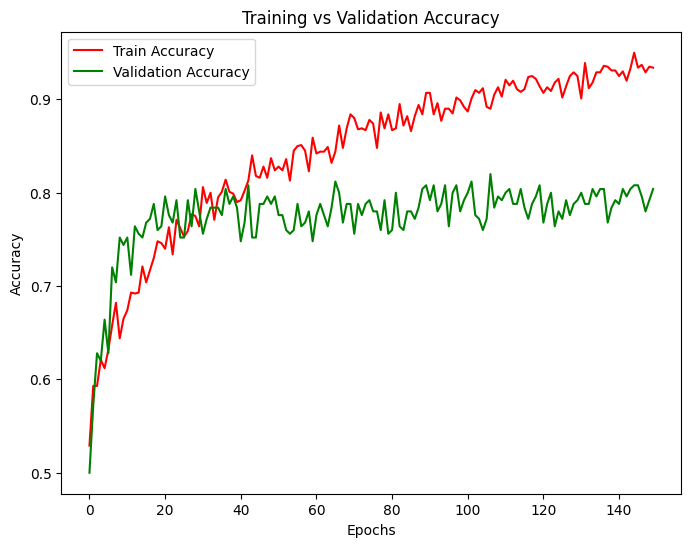

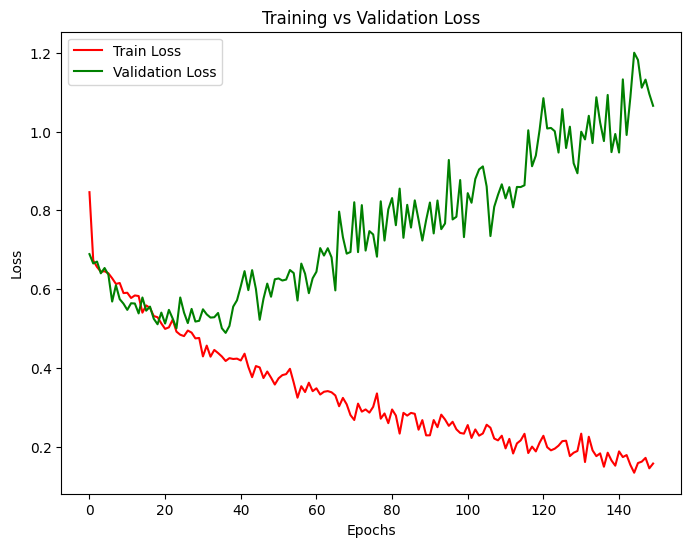

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(model_history.history['accuracy'], 'r', label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], 'g', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(8,6))
plt.plot(model_history.history['loss'], 'r', label='Train Loss')
plt.plot(model_history.history['val_loss'], 'g', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

Podemos ver en el gráfico ***Training vs Validation Accuracy*** que el *training accuracy* aumenta, lo que significa que el modelo cada vez memoriza mejor los ejemplos de entrenamiento. Sin embargo, el *validation accuracy* se mantiene constante, lo que significa que el modelo no generaliza bien a datos nuevos y empieza a fallar fuera del conjunto de entrenamiento.

También vemos que el gráfico de ***Training vs Validation Loss*** sugiere que sobre la época 20 hay sobreajuste, pues vemos que el *training loss* sigue decreciendo mientras que el *validation loss* comienza a aumentar.

## Guardamos el Modelo

In [ ]:
pickle.dump(model, open("../models/ANN_default.sav", "wb"))

# Optimizar el Modelo

## ModelCheckpoint y EarlyStopping

Al modelo previamente definido agregaremos nuevos parámetros:

- *Checkpoint*, que guarda el mejor modelo en un archivo
- *EarlyStopping*, que detiene el entrenamiento si el modelo deja de mejorar en validación.
- *ReduceLROnPlateau*, que baja el learning rate automáticamente cuando el modelo deja de mejorar.

In [9]:
set_random_seed(42)

model_opt = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation="relu"),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model_opt.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

checkpoint = ModelCheckpoint("best_model.h5", 
                             monitor="val_loss", 
                             save_best_only=True, 
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=8, 
                           verbose=1, 
                           min_delta=1e-4, 
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=4, 
                              verbose=1, 
                              min_delta=1e-4)

callbacks_list = [checkpoint, early_stop, reduce_lr]

In [10]:
model_history_opt = model_opt.fit(  
    train_generator,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = train_generator.samples // batch_size,
    callbacks = callbacks_list)

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.5130 - loss: 1.0622
Epoch 1: val_loss improved from None to 0.68885, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 826ms/step - accuracy: 0.5290 - loss: 0.8461 - val_accuracy: 0.5000 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.5827 - loss: 0.6812
Epoch 2: val_loss improved from 0.68885 to 0.66503, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 849ms/step - accuracy: 0.5930 - loss: 0.6728 - val_accuracy: 0.5720 - val_loss: 0.6650 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.5838 - loss: 0.6590
Epoch 3: val_loss did not improve from 0.66503
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 841ms/step - accuracy: 0.5930 - loss: 0.6561 - val_accuracy: 0.6280 - val_loss: 0.6699 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.6382 - loss: 0.6330
Epoch 4: val_loss improved from 0.66503 to 0.64008, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 835ms/step - accuracy: 0.6210 - loss: 0.6444 - val_accuracy: 0.6200 - val_loss: 0.6401 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.6166 - loss: 0.6224
Epoch 5: val_loss did not improve from 0.64008
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 823ms/step - accuracy: 0.6120 - loss: 0.6453 - val_accuracy: 0.6640 - val_loss: 0.6535 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.6247 - loss: 0.6429
Epoch 6: val_loss improved from 0.64008 to 0.63661, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 811ms/step - accuracy: 0.6320 - loss: 0.6401 - val_accuracy: 0.6280 - val_loss: 0.6366 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.6369 - loss: 0.6414
Epoch 7: val_loss improved from 0.63661 to 0.56829, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 849ms/step - accuracy: 0.6580 - loss: 0.6275 - val_accuracy: 0.7200 - val_loss: 0.5683 - learning_rate: 0.0010
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.6830 - loss: 0.6153
Epoch 8: val_loss did not improve from 0.56829
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 826ms/step - accuracy: 0.6820 - loss: 0.6131 - val_accuracy: 0.7040 - val_loss: 0.6097 - learning_rate: 0.0010
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.6274 - loss: 0.6254
Epoch 9: val_loss did not improve from 0.56829
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 797ms/step - accuracy: 0.6440 - loss: 0.6155 - val_accuracy: 0.7520 - val_loss: 0.5744 - learning_rate: 0.0010
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.6970 - loss: 0.5762
Epoch 10: val_loss improved from 0.56829 to 0.56292, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 853ms/step - accuracy: 0.6650 - loss: 0.5898 - val_accuracy: 0.7440 - val_loss: 0.5629 - learning_rate: 0.0010
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.6800 - loss: 0.5893
Epoch 11: val_loss improved from 0.56292 to 0.54716, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 828ms/step - accuracy: 0.6740 - loss: 0.5907 - val_accuracy: 0.7520 - val_loss: 0.5472 - learning_rate: 0.0010
Epoch 12/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.7039 - loss: 0.5752
Epoch 12: val_loss did not improve from 0.54716
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 844ms/step - accuracy: 0.6930 - loss: 0.5774 - val_accuracy: 0.7120 - val_loss: 0.5640 - learning_rate: 0.0010
Epoch 13/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.7244 - loss: 0.5578
Epoch 13: val_loss did not improve from 0.54716
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 846ms/step - accuracy: 0.6920 - loss: 0.5838 - val_accuracy: 0.7640 - val_loss: 0.5633 - learning_rate: 0.0010
Epoch 14/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.7026 - loss: 0.5733
Epoch 14: val_loss improved from 0.54716 to 0.53816, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 821ms/step - accuracy: 0.6930 - loss: 0.5823 - val_accuracy: 0.7560 - val_loss: 0.5382 - learning_rate: 0.0010
Epoch 15/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.7330 - loss: 0.5332
Epoch 15: val_loss did not improve from 0.53816
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 866ms/step - accuracy: 0.7210 - loss: 0.5401 - val_accuracy: 0.7520 - val_loss: 0.5786 - learning_rate: 0.0010
Epoch 16/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.7059 - loss: 0.5571
Epoch 16: val_loss did not improve from 0.53816
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 835ms/step - accuracy: 0.7040 - loss: 0.5585 - val_accuracy: 0.7680 - val_loss: 0.5451 - learning_rate: 0.0010
Epoch 17/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.7200 - loss: 0.5487
Epoch 17: val_loss did not improve from 0.53816
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 806ms/step - accuracy: 0.7170 - loss: 0.5520 - val_accuracy: 0.7720 - val_loss: 0.5555 - learning_rate: 0.0010
Epoch 18/150
32/32 ━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 865ms/step - accuracy: 0.7300 - loss: 0.5315 - val_accuracy: 0.7880 - val_loss: 0.5247 - learning_rate: 0.0010
Epoch 19/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.7568 - loss: 0.5128
Epoch 19: val_loss improved from 0.52468 to 0.51061, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 819ms/step - accuracy: 0.7480 - loss: 0.5285 - val_accuracy: 0.7600 - val_loss: 0.5106 - learning_rate: 0.0010
Epoch 20/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.7331 - loss: 0.5238
Epoch 20: val_loss did not improve from 0.51061
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 811ms/step - accuracy: 0.7460 - loss: 0.5128 - val_accuracy: 0.7640 - val_loss: 0.5402 - learning_rate: 0.0010
Epoch 21/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.7344 - loss: 0.5022
Epoch 21: val_loss did not improve from 0.51061
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 799ms/step - accuracy: 0.7400 - loss: 0.4989 - val_accuracy: 0.7960 - val_loss: 0.5125 - learning_rate: 0.0010
Epoch 22/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.7881 - loss: 0.4699
Epoch 22: val_loss did not improve from 0.51061
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 811ms/step - accuracy: 0.7630 - loss: 0.5028 - val_accuracy: 0.7760 - val_loss: 0.5472 - learning_rate: 0.0010
Epoch 23/150
32/32 ━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 824ms/step - accuracy: 0.7950 - loss: 0.4507 - val_accuracy: 0.7800 - val_loss: 0.5081 - learning_rate: 1.0000e-04
Epoch 26/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.7860 - loss: 0.4244
Epoch 26: val_loss did not improve from 0.50809
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 797ms/step - accuracy: 0.7900 - loss: 0.4304 - val_accuracy: 0.7880 - val_loss: 0.5089 - learning_rate: 1.0000e-04
Epoch 27/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.7969 - loss: 0.4345
Epoch 27: val_loss did not improve from 0.50809
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 800ms/step - accuracy: 0.7900 - loss: 0.4433 - val_accuracy: 0.7840 - val_loss: 0.5113 - learning_rate: 1.0000e-04
Epoch 28/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.8138 - loss: 0.4097
Epoch 28: val_loss did not improve from 0.50809
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 799ms/step - accuracy: 0.7880 - loss: 0.4352 - val_accuracy: 0.7880 - val_loss: 0.5111 - learning_rate: 1.0000e-04
Epoch 29

Con un *accuracy* del 78%, el modelo aprendió muy bien el set de entrenamiento, pero el *validation accuracy* se quedó en 78%, lo que indica que no hubo. El *early stopping* evitó que el modelo se siga memorizando y lo dejó en el punto más balanceado, que es la época 25.

In [11]:
loss, accuracy = model_opt.evaluate(train_generator)
print(f"Train Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 358ms/step - accuracy: 0.7760 - loss: 0.4503
Train Accuracy: 0.7760


In [12]:
loss, accuracy = model_opt.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.7800 - loss: 0.5081
Test Accuracy: 0.7800


## Matriz de Confusión

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step


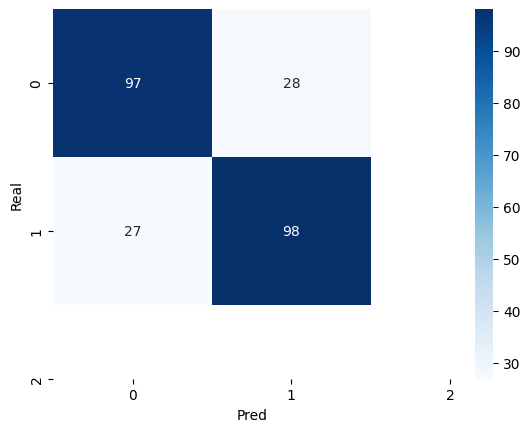

In [19]:
y_true = test_generator.classes
y_pred = model_opt.predict(test_generator, verbose=1)
y_pred_classes = (y_pred > 0.5).astype("int32").ravel()

from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(y_true, y_pred_classes)
cm = confusion_matrix(y_true, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2],
            yticklabels=[0,1,2])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()

En la matriz de confusión vemos, de forma más clara, que el modelo no es capaz de generalizar todas las instancias y que sobre el 20% de los valores son FP y FN.

## Graficamos los resultados del entrenamiento

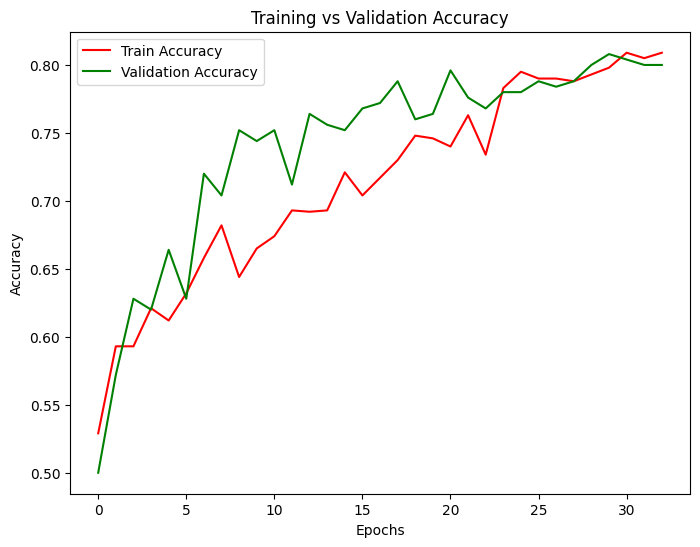

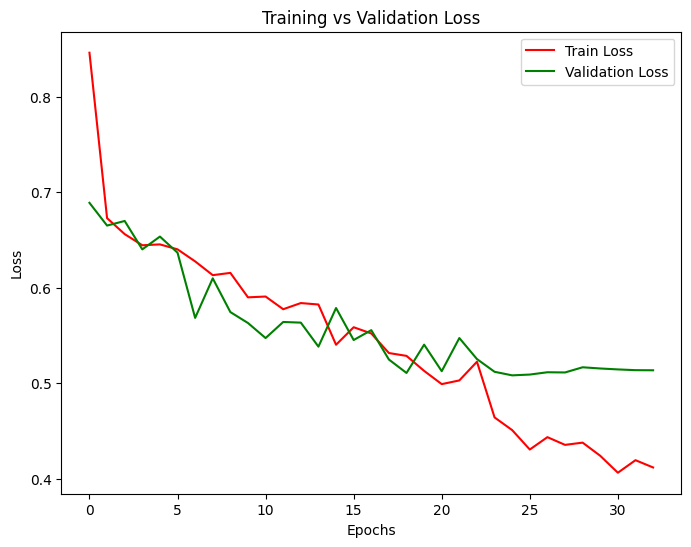

In [15]:
plt.figure(figsize=(8,6))
plt.plot(model_history_opt.history['accuracy'], 'r', label='Train Accuracy')
plt.plot(model_history_opt.history['val_accuracy'], 'g', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(8,6))
plt.plot(model_history_opt.history['loss'], 'r', label='Train Loss')
plt.plot(model_history_opt.history['val_loss'], 'g', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

Podemos ver en el gráfico ***Training vs Validation Accuracy*** que tanto el *train accuracy* como el *validation accuracy* aumentan, lo que sugiere que el modelo cada vez memoriza mejor los ejemplos de entrenamiento y generaliza razonablemente bien.

También vemos que el gráfico de ***Training vs Validation Loss*** que sobre la época 25 el *training loss* se mantiene constante mientras que el *validation loss* comienza a decrecer. Por esto el modelo hace un early stopping y se considera la época 25 como el punto óptimo de entrenamiento.

## Guardamos el Modelo

In [16]:
pickle.dump(model_opt, open("../models/ANN_opt.sav", "wb"))